In [1]:
# Step 1
# Importing necessary libraries and modules for the project
# Importing the necessary libraries and modules for the project

from joblib import dump
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [2]:

# File paths for the datasets used in the project
# The datasets are stored in the Datasets folder
# The datasets are in CSV format

file_paths = {
    "LDAP": "./Datasets/DDoS_LDAP.csv",
    "DNS": "./Datasets/DDoS_DNS.csv",
    "NetBIOS": "./Datasets/DDoS_NetBIOS.csv",
    "UDP": "./Datasets/DDoS_UDP.csv",
    "Syn" : "./Datasets/DDoS_syn.csv",
    "MSSQL" : "./Datasets/DDoS_MSSQL.csv"
}


In [3]:
# Step 2: Reading the files using pandas
# The datasets are read using the pandas library
# The datasets are stored in dataframes

# Read CSV using pandas
def read_csv_pandas(file_path):
    return pd.read_csv(file_path, dtype={"SimillarHTTP": str, "Inbound": str, "Class": str, "Label": str})

# Read from CSV files using pandas
df1 = read_csv_pandas(file_paths["LDAP"])
df2 = read_csv_pandas(file_paths["NetBIOS"])
df3 = read_csv_pandas(file_paths["DNS"])
df4 = read_csv_pandas(file_paths["UDP"])
df5 = read_csv_pandas(file_paths["Syn"])
df6 = read_csv_pandas(file_paths["MSSQL"])


In [4]:

# Combine datasets 
# Combing all the datasets to get data
# The datasets are combined using the pandas concat function
# The datasets are combined into two dataframes, one for training and the other for testing

df_train = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True, sort=False)
df_test = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True, sort=False)

# Assign class labels
# Assigning class labels to the datasets
# The class labels are assigned based on the index of the datasets

df_train["Class"] = np.where(df_train.index < len(df3), 1, 0)
df_test["Class"] = np.where(df_test.index < len(df1), 1, 0)


In [5]:
df1.columns

Index(['Unnamed: 0', 'Flow ID', ' Source IP', ' Source Port',
       ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',
       ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Len

In [6]:
# Normalize column names to lower case and drop rows with missing values

# Normalize column names to lower case
df_train.columns = df_train.columns.str.lower()
df_test.columns = df_test.columns.str.lower()

# Drop rows with missing values
df_test = df_test.dropna().sample(n=3000, random_state=42).reset_index(drop=True)
df_train.dropna(inplace=True)

In [7]:
# Update selected_features to match the column names in df_train
# Selecting the features to be used in the model
# The features are selected based on the column names in the dataset df_train
# The selected features are stored in a list

selected_features = [
    'packet length min', 'average packet size', 'avg fwd segment size',
    'fwd packet length min', 'urg flag count', 'protocol', 'cwe flag count',
    'fwd packet length max', 'fwd packet length mean', 'ack flag count',
    'avg bwd segment size', 'bwd packet length min', 'packet length max',
    'bwd packet length max', 'rst flag count', 'init_win_bytes_forward',
    'flow duration', 'packet length mean', 'bwd packet length mean', 'Class'
]


In [8]:

# Limit dataset size
df_train = df_train.sample(n=3000, random_state=42).reset_index(drop=True)
df_train.shape

(3000, 89)

In [9]:

# Strip column names of leading and trailing whitespaces
# Stripping the column names of leading and trailing whitespaces
# The column names are stripped using the str.strip() function

df_train.columns = df_train.columns.str.strip()
df_test.columns = df_test.columns.str.strip()


In [10]:

# Filter available features in the dataset
# Filtering the available features in the dataset
# The available features are filtered based on the selected features
# The available features are stored in a list

available_features = [col for col in selected_features if col in df_train.columns]
print(available_features)

['average packet size', 'avg fwd segment size', 'fwd packet length min', 'urg flag count', 'protocol', 'cwe flag count', 'fwd packet length max', 'fwd packet length mean', 'ack flag count', 'avg bwd segment size', 'bwd packet length min', 'bwd packet length max', 'rst flag count', 'init_win_bytes_forward', 'flow duration', 'packet length mean', 'bwd packet length mean']


In [11]:

# Feature selection and data splitting
# Splitting the data into features and target variables
# The data is split into training and testing sets
# The features are stored in X_train and X_test
# The target variables are stored in y_train and y_test

X_train = df_train[available_features]
y_train = df_train["class"]
X_test = df_test[available_features]
y_test = df_test["class"]


In [12]:

# Function to remove highly correlated features
# Removing highly correlated features
# The function removes highly correlated features from the dataset
# The function takes the dataset and a threshold value as input
# The threshold value is used to determine the correlation between features
# The function returns the dataset with highly correlated features removed

def correlation(dataset, threshold=0.8):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr


In [13]:

# Drop correlated features from the dataset
# Dropping correlated features from the dataset using the correlation function
# The correlated features are removed from the dataset
# The dataset is updated with the correlated features removed

ncorr_features = correlation(X_train)
X_train.drop(ncorr_features, axis=1, inplace=True)
X_test.drop(ncorr_features, axis=1, inplace=True)


C:\Users\telag\AppData\Local\Temp\ipykernel_17484\614259328.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(ncorr_features, axis=1, inplace=True)
C:\Users\telag\AppData\Local\Temp\ipykernel_17484\614259328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(ncorr_features, axis=1, inplace=True)


In [14]:

# Scale features using MinMaxScaler
# Scaling the features using MinMaxScaler
# The features are scaled using the MinMaxScaler
# The scaled features are stored in X_train_scaled and X_test_scaled

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [15]:

# Handling class imbalance using the SMOTE technique
# The class imbalance is handled using the SMOTE technique
# The SMOTE technique is applied to the training set
# The resampled training set is stored in X_train_resampled and y_train_resampled

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


<Axes: xlabel='down/up ratio', ylabel='count'>

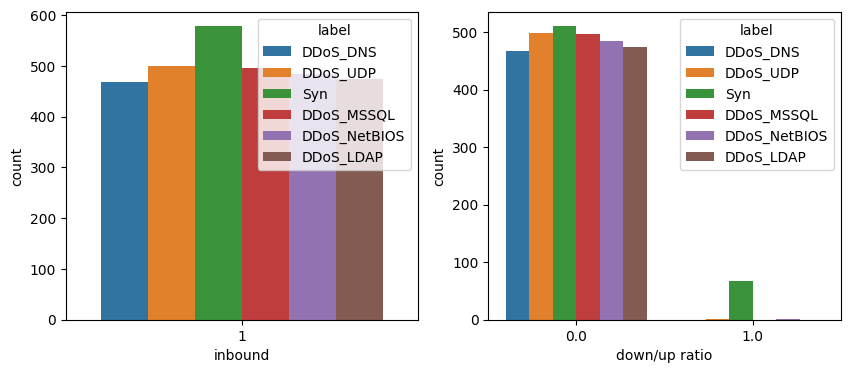

In [16]:
# Plot showing the distribution of the classes(attacks) from the  combined dataset
# The distribution of the classes is shown using a countplot
# The countplot shows the distribution of the classes based on the inbound and down/up ratio features

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(x='inbound', data=df_train, hue='label', ax=ax[0])
sns.countplot(x='down/up ratio', data=df_train, hue='label', ax=ax[1])

Text(0, 0.5, 'Flow Packets/s')

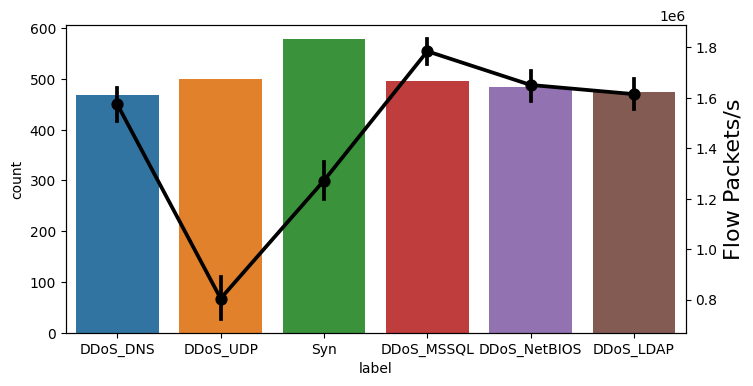

In [17]:
# Plot showing the flow packets per second for each class from the combined dataset
# The flow packets per second for each class is shown using a pointplot
# The pointplot shows the flow packets per second for each class

plt.figure(figsize=(8,4))
g1 = sns.countplot(x='label', hue='label', data=df_train)
gt = g1.twinx()
gt = sns.pointplot(y='flow packets/s', x='label', data=df_train, color='black', legend=False)
gt.set_ylabel("Flow Packets/s", fontsize=16)

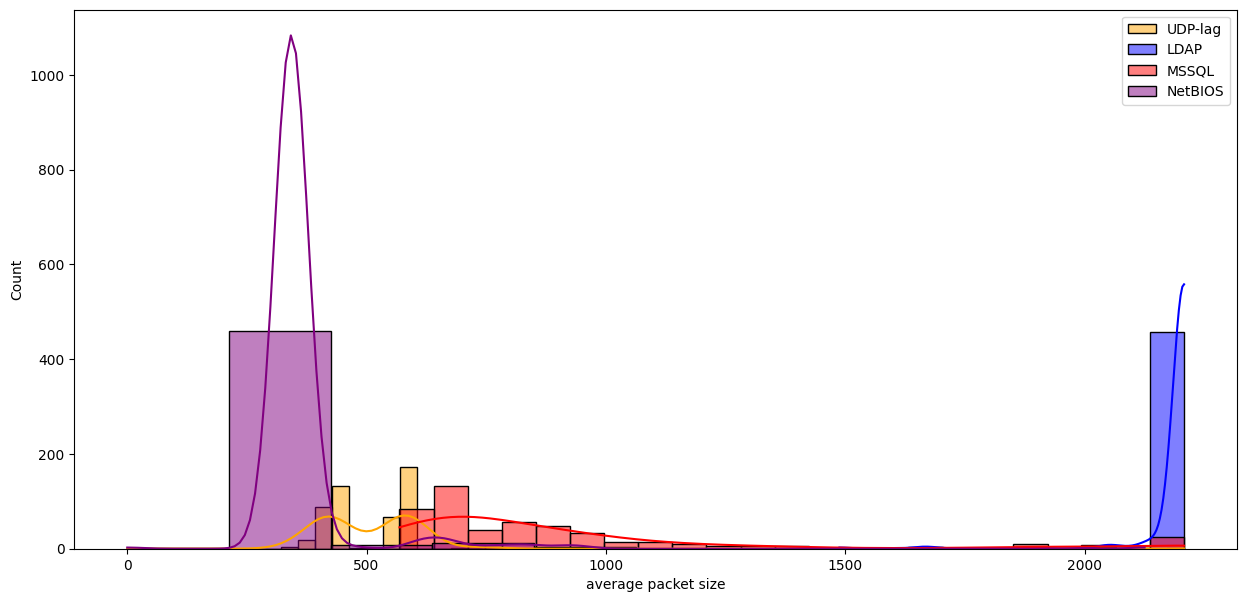

In [18]:
# This plot shows the average packet size for each class in the combined dataset
# The average packet size for each class is shown using a histogram
# The histogram shows the average packet size for each class

plt.figure(figsize=(15, 7))
sns.histplot(df_train[df_train['label'] == 'DDoS_UDP']['average packet size'], color='orange', label='UDP-lag', kde=True)
sns.histplot(df_train[df_train['label'] == 'DDoS_LDAP']['average packet size'], color='blue', label='LDAP', kde=True)
sns.histplot(df_train[df_train['label'] == 'DDoS_MSSQL']['average packet size'], color='red', label='MSSQL', kde=True)
sns.histplot(df_train[df_train['label'] == 'DDoS_NetBIOS']['average packet size'], color='purple', label='NetBIOS', kde=True)
sns.histplot(df_train[df_train['label'] == 'DDoS_syn']['average packet size'], color='brown', label='Syn', kde=True)
sns.histplot(df_train[df_train['label'] == 'BENIGN']['average packet size'], color='green', label='NORMAL', kde=True)

plt.legend()
plt.show()

In [19]:
# Train models using the resampled data
# This code trains logistic regression, KNN, and SVM models using the resampled training data.
# The trained models are saved for later use.

from sklearn.neighbors import KNeighborsClassifier

logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_resampled, y_train_resampled)
print("Logistic Regression Model Trained")

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_resampled, y_train_resampled)
print("KNN Model Trained")

svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_resampled, y_train_resampled)
print("SVM Model Trained")

Logistic Regression Model Trained
KNN Model Trained
SVM Model Trained


In [20]:
# Model evaluation using the datasets
# This code evaluates the trained models using the test data.
# The accuracy of the models is calculated using the test data.
# The accuracy of the models is printed to the console.

models = {'Logistic Regression': logreg_model, 'KNN': knn_model, 'SVM': svm_model}

for name, model in models.items():
    y_pred_test = model.predict(X_test_scaled)
    print(f"{name} Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")


Logistic Regression Test Accuracy: 0.8410
KNN Test Accuracy: 0.8797
SVM Test Accuracy: 0.8413


In [21]:
# Save models into the local directory
dump(logreg_model, 'logreg_model.joblib')
dump(knn_model, 'knn_model.joblib')
dump(svm_model, 'svm_model.joblib')

print("Models saved successfully.")

Models saved successfully.


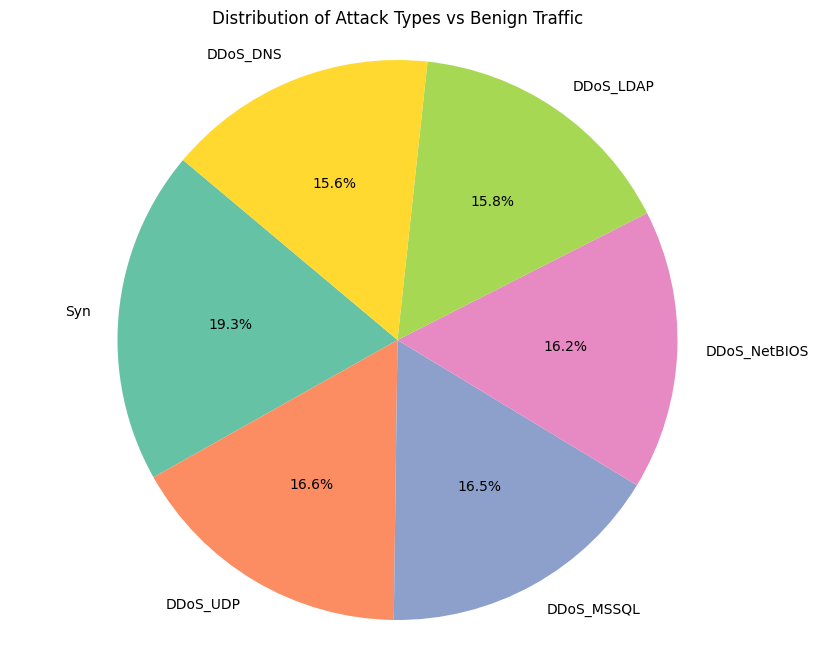

In [22]:
# Count the occurrences of each label
label_counts = df_test['label'].value_counts()

# Define labels and sizes for the pie chart
labels = label_counts.index
sizes = label_counts.values

# Plot the pie chart showing the distribution of attack types vs benign traffic
# The pie chart shows the distribution of the attack types based on the number of occurrences

plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2", len(labels)))
plt.title('Distribution of Attack Types vs Benign Traffic')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

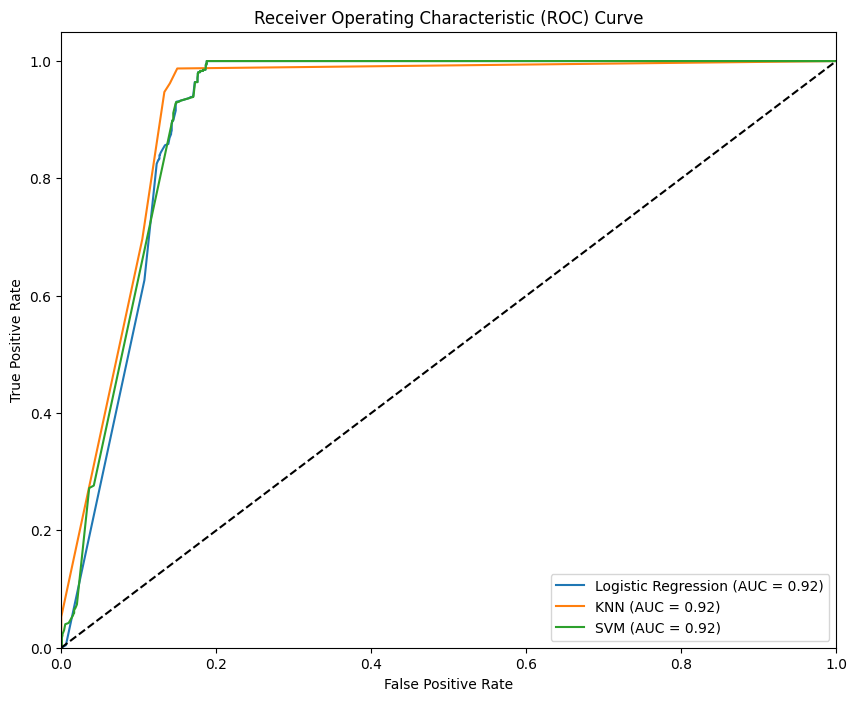

In [23]:
# Generate ROC curves for the models
# This code generates ROC curves for the trained models using the test data.
# The ROC curves are a useful way to visualize the performance of the models.
# The area under the curve (AUC) is a measure of the model's ability to distinguish between classes.
# A higher AUC indicates better performance.

plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [24]:
# Evaluate models using classification report
# This code evaluates the trained models using the test data.
# The classification report provides a detailed summary of the model's performance.
# The classification report includes metrics such as precision, recall, F1-score, and support.

from sklearn.metrics import classification_report# Evaluate models

# Evaluate models using classification report
for name, model in models.items():
    y_pred_test = model.predict(X_test_scaled)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred_test))
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    print("\n")

Model: Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.81      0.90      2526
           1       0.50      0.99      0.66       474

    accuracy                           0.84      3000
   macro avg       0.75      0.90      0.78      3000
weighted avg       0.92      0.84      0.86      3000

Test Accuracy: 0.8410


Model: KNN
              precision    recall  f1-score   support

           0       0.99      0.87      0.92      2526
           1       0.57      0.95      0.71       474

    accuracy                           0.88      3000
   macro avg       0.78      0.91      0.82      3000
weighted avg       0.92      0.88      0.89      3000

Test Accuracy: 0.8797


Model: SVM
              precision    recall  f1-score   support

           0       1.00      0.81      0.90      2526
           1       0.50      0.99      0.66       474

    accuracy                           0.84      3000
   macro avg       0.75      0.

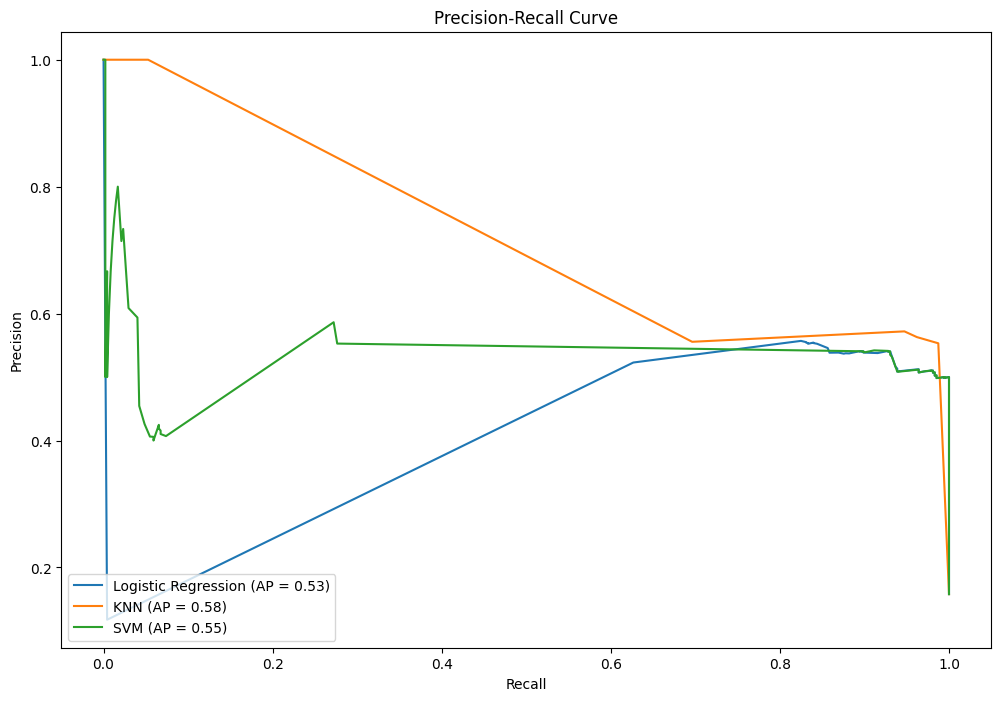

In [25]:
# Evaluate models using classification report
# This code evaluates the trained models using the test data.
# The classification report provides a detailed summary of the model's performance.
# The classification report includes metrics such as precision, recall, F1-score, and support.
# Generate precision-recall curves for the models and compare them

from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(12, 8))

for name, model in models.items():
    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    average_precision = average_precision_score(y_test, y_pred_prob)
    plt.plot(recall, precision, label=f'{name} (AP = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()